In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC  # <-- ADDED
from sklearn.utils.class_weight import compute_sample_weight
import warnings

warnings.filterwarnings('ignore')

In [18]:
# Load the dataset
data = pd.read_csv('student-por.csv')
print("Dataset Loaded Successfully!\n")

# Perform Feature Engineering
print("Performing Feature Engineering...")
data['G_avg'] = (data['G1'] + data['G2']) / 2
data['total_alcohol'] = data['Dalc'] + data['Walc']
data['study_vs_play'] = data['studytime'] / (data['freetime'] + 1)

Dataset Loaded Successfully!

Performing Feature Engineering...


In [19]:
# One-Hot Encoding for categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns
data_processed = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

# Define features (X) and target (y)
X = data_processed.drop('G3', axis=1, errors='ignore')
bins = [-1, 9, 13, 20]
labels = [0, 1, 2]  # 0: High, 1: Medium, 2: Low
y = pd.cut(data_processed['G3'], bins=bins, labels=labels)

print("Data Preprocessing Completed.")

Data Preprocessing Completed.


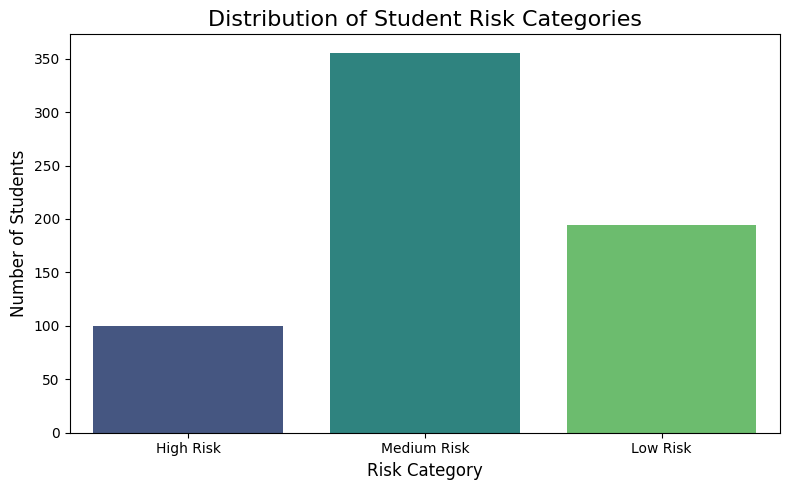

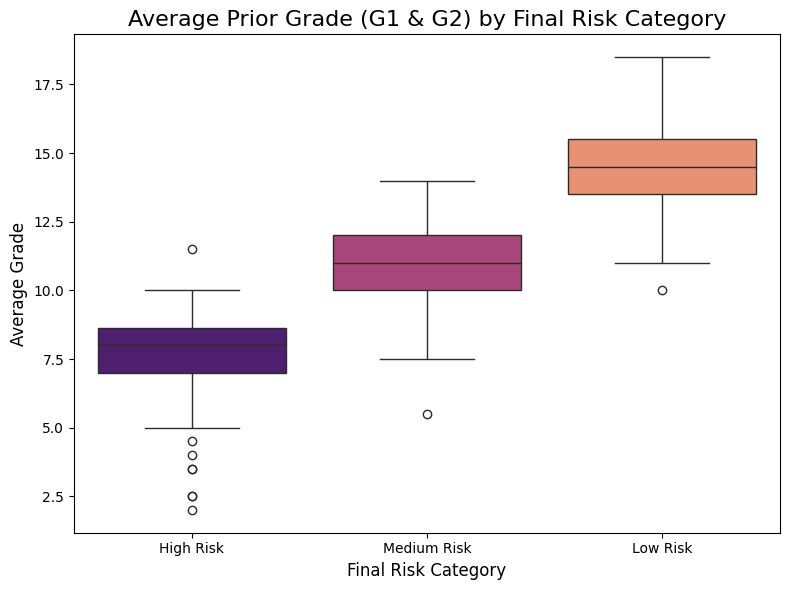

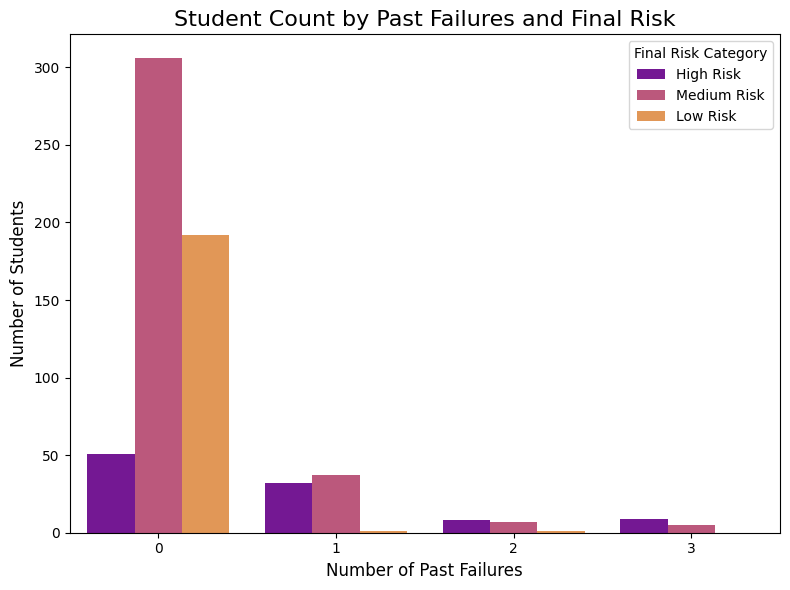

In [20]:
# ==============================================================================
# ## Exploratory Data Analysis (EDA)
# ==============================================================================

# First, add a 'Risk_Category' column with text labels to the original dataframe for easy plotting
risk_map = {0: 'High Risk', 1: 'Medium Risk', 2: 'Low Risk'}
data['Risk_Category'] = y.map(risk_map)

# --- Plot 1: Distribution of Student Risk Categories ---
plt.figure(figsize=(8, 5))
sns.countplot(x='Risk_Category', data=data, order=['High Risk', 'Medium Risk', 'Low Risk'], palette='viridis')
plt.title('Distribution of Student Risk Categories', fontsize=16)
plt.xlabel('Risk Category', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.tight_layout()
plt.show()

# --- Plot 2: Average Grade (G1 & G2) by Risk Category ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='Risk_Category', y='G_avg', data=data, order=['High Risk', 'Medium Risk', 'Low Risk'], palette='magma')
plt.title('Average Prior Grade (G1 & G2) by Final Risk Category', fontsize=16)
plt.xlabel('Final Risk Category', fontsize=12)
plt.ylabel('Average Grade', fontsize=12)
plt.tight_layout()
plt.show()

# --- Plot 3: Past Failures by Final Risk Category ---
plt.figure(figsize=(8, 6))
sns.countplot(x='failures', hue='Risk_Category', data=data, hue_order=['High Risk', 'Medium Risk', 'Low Risk'], palette='plasma')
plt.title('Student Count by Past Failures and Final Risk', fontsize=16)
plt.xlabel('Number of Past Failures', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.legend(title='Final Risk Category')
plt.tight_layout()
plt.show()


In [21]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ensure both train and test sets have the same columns after one-hot encoding
train_cols = X_train.columns
test_cols = X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
X_test = X_test[train_cols]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Splitting and Scaling Completed.\n")

# Dictionaries to store results and trained models
model_results = {}
trained_models = {}


Data Splitting and Scaling Completed.



In [22]:
# --- Helper function to save predictions ---
def save_predictions(model_name, X_test_df, y_test_series, predictions):
    filename = f'{model_name.lower().replace(" ", "_")}_predictions.csv'
    print(f"\nGenerating and saving predictions for {model_name}...")
    # Use the unscaled X_test for interpretable output
    output_df = X_test_df.copy()
    output_df['Actual_Risk_Category_Num'] = y_test_series.values
    output_df['Predicted_Risk_Category_Num'] = predictions
    risk_map = {0: 'High Risk', 1: 'Medium Risk', 2: 'Low Risk'}
    output_df['Actual_Risk_Category'] = output_df['Actual_Risk_Category_Num'].map(risk_map)
    output_df['Predicted_Risk_Category'] = output_df['Predicted_Risk_Category_Num'].map(risk_map)
    output_df[['G_avg', 'failures', 'absences', 'total_alcohol', 'Actual_Risk_Category', 'Predicted_Risk_Category']].to_csv(filename, index=False)
    print(f"Successfully saved predictions to '{filename}'")

In [23]:
print("\n===== Starting Tuning for Logistic Regression =====")
param_grid_lr = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
lr_grid = GridSearchCV(estimator=LogisticRegression(random_state=42, class_weight='balanced'),
                       param_grid=param_grid_lr, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted')
lr_grid.fit(X_train_scaled, y_train)
best_lr_model = lr_grid.best_estimator_
trained_models['Logistic Regression'] = best_lr_model
y_pred_lr = best_lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
model_results['Logistic Regression'] = {'accuracy': accuracy_lr, 'predictions': y_pred_lr}

print("\n----- Tuned Logistic Regression Evaluation -----")
print(f"Best Parameters: {lr_grid.best_params_}")
print(f"\nFinal Test Accuracy: {accuracy_lr:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr, target_names=['High Risk', 'Medium Risk', 'Low Risk']))
save_predictions('Logistic Regression', X_test, y_test, y_pred_lr)


===== Starting Tuning for Logistic Regression =====
Fitting 5 folds for each of 8 candidates, totalling 40 fits

----- Tuned Logistic Regression Evaluation -----
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Final Test Accuracy: 0.8308

Classification Report:
               precision    recall  f1-score   support

   High Risk       0.74      0.70      0.72        20
 Medium Risk       0.90      0.77      0.83        71
    Low Risk       0.78      1.00      0.88        39

    accuracy                           0.83       130
   macro avg       0.81      0.82      0.81       130
weighted avg       0.84      0.83      0.83       130


Generating and saving predictions for Logistic Regression...
Successfully saved predictions to 'logistic_regression_predictions.csv'


In [24]:
print("\n===== Starting Tuning for Random Forest =====")
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'criterion': ['entropy']}
rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
                       param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted')
rf_grid.fit(X_train_scaled, y_train)
best_rf_model = rf_grid.best_estimator_
trained_models['Random Forest'] = best_rf_model
y_pred_rf = best_rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
model_results['Random Forest'] = {'accuracy': accuracy_rf, 'predictions': y_pred_rf}

print("\n----- Tuned Random Forest Evaluation -----")
print(f"Best Parameters: {rf_grid.best_params_}")
print(f"\nFinal Test Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=['High Risk', 'Medium Risk', 'Low Risk']))
save_predictions('Random Forest', X_test, y_test, y_pred_rf)


===== Starting Tuning for Random Forest =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits



----- Tuned Random Forest Evaluation -----
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Final Test Accuracy: 0.8692

Classification Report:
               precision    recall  f1-score   support

   High Risk       0.87      0.65      0.74        20
 Medium Risk       0.88      0.89      0.88        71
    Low Risk       0.86      0.95      0.90        39

    accuracy                           0.87       130
   macro avg       0.87      0.83      0.84       130
weighted avg       0.87      0.87      0.87       130


Generating and saving predictions for Random Forest...
Successfully saved predictions to 'random_forest_predictions.csv'


In [25]:
print("\n===== Starting Tuning for XGBoost =====")
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
param_grid_xgb = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1], 'subsample': [0.8, 1.0]}
xgb_grid = GridSearchCV(estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
                        param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted')
xgb_grid.fit(X_train_scaled, y_train, sample_weight=sample_weights)
best_xgb_model = xgb_grid.best_estimator_
trained_models['XGBoost'] = best_xgb_model
y_pred_xgb = best_xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
model_results['XGBoost'] = {'accuracy': accuracy_xgb, 'predictions': y_pred_xgb}

print("\n----- Tuned XGBoost Evaluation -----")
print(f"Best Parameters: {xgb_grid.best_params_}")
print(f"\nFinal Test Accuracy: {accuracy_xgb:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=['High Risk', 'Medium Risk', 'Low Risk']))
save_predictions('XGBoost', X_test, y_test, y_pred_xgb)


===== Starting Tuning for XGBoost =====
Fitting 5 folds for each of 36 candidates, totalling 180 fits

----- Tuned XGBoost Evaluation -----
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Final Test Accuracy: 0.8615

Classification Report:
               precision    recall  f1-score   support

   High Risk       0.72      0.90      0.80        20
 Medium Risk       0.92      0.82      0.87        71
    Low Risk       0.86      0.92      0.89        39

    accuracy                           0.86       130
   macro avg       0.83      0.88      0.85       130
weighted avg       0.87      0.86      0.86       130


Generating and saving predictions for XGBoost...
Successfully saved predictions to 'xgboost_predictions.csv'


In [26]:
# ==============================================================================
# ## Model 4: Support Vector Machine (SVM) Tuning
# ==============================================================================
print("\n===== Starting Tuning for Support Vector Machine (SVM) =====")
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf']
}
# Note: SVC also takes class_weight='balanced' directly
svm_grid = GridSearchCV(estimator=SVC(random_state=42, class_weight='balanced', probability=True),
                       param_grid=param_grid_svm, cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted')
svm_grid.fit(X_train_scaled, y_train)
best_svm_model = svm_grid.best_estimator_
trained_models['Support Vector Machine'] = best_svm_model
y_pred_svm = best_svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
model_results['Support Vector Machine'] = {'accuracy': accuracy_svm, 'predictions': y_pred_svm}

print("\n----- Tuned SVM Evaluation -----")
print(f"Best Parameters: {svm_grid.best_params_}")
print(f"\nFinal Test Accuracy: {accuracy_svm:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, target_names=['High Risk', 'Medium Risk', 'Low Risk']))
save_predictions('Support Vector Machine', X_test, y_test, y_pred_svm)


===== Starting Tuning for Support Vector Machine (SVM) =====
Fitting 5 folds for each of 6 candidates, totalling 30 fits

----- Tuned SVM Evaluation -----
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Final Test Accuracy: 0.7923

Classification Report:
               precision    recall  f1-score   support

   High Risk       0.91      0.50      0.65        20
 Medium Risk       0.79      0.85      0.82        71
    Low Risk       0.77      0.85      0.80        39

    accuracy                           0.79       130
   macro avg       0.82      0.73      0.76       130
weighted avg       0.80      0.79      0.79       130


Generating and saving predictions for Support Vector Machine...
Successfully saved predictions to 'support_vector_machine_predictions.csv'




===== Final Accuracy Comparison of Tuned Models =====
                    Model  Test Accuracy
0     Logistic Regression       0.830769
1           Random Forest       0.869231
2                 XGBoost       0.861538
3  Support Vector Machine       0.792308


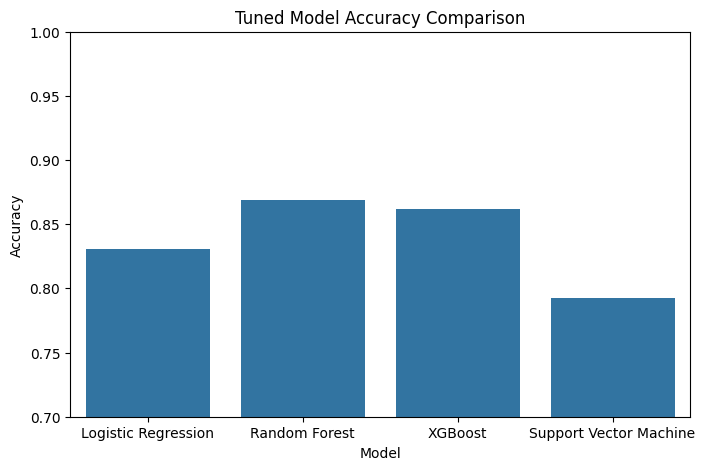



===== Final Overfitting Comparison of Tuned Models =====
                        Training Accuracy  Test Accuracy  Difference
Logistic Regression              0.832370       0.830769    0.001601
Random Forest                    0.990366       0.869231    0.121135
XGBoost                          0.861272       0.861538   -0.000267
Support Vector Machine           1.000000       0.792308    0.207692


In [29]:
# ==============================================================================
# ## Final Model Comparison and Analysis
# ==============================================================================
print("\n\n===== Final Accuracy Comparison of Tuned Models =====")
accuracy_data = {model: results['accuracy'] for model, results in model_results.items()}
results_df = pd.DataFrame(list(accuracy_data.items()), columns=['Model', 'Test Accuracy'])
print(results_df)


plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Test Accuracy', data=results_df)
plt.title('Tuned Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.show()

# --- Overfitting Check ---
print("\n\n===== Final Overfitting Comparison of Tuned Models =====")
overfitting_results = {}
for model_name, model in trained_models.items():
    y_pred_train = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = model_results[model_name]['accuracy']
    overfitting_results[model_name] = {'Training Accuracy': train_accuracy, 'Test Accuracy': test_accuracy}

overfitting_df = pd.DataFrame.from_dict(overfitting_results, orient='index')
overfitting_df['Difference'] = overfitting_df['Training Accuracy'] - overfitting_df['Test Accuracy']
print(overfitting_df)



===== Generating Confusion Matrix Plots =====


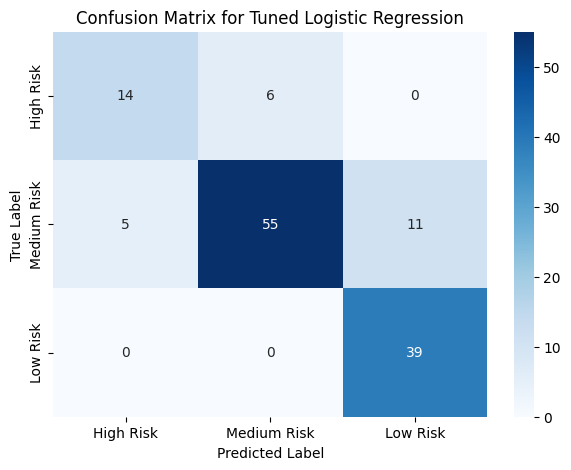

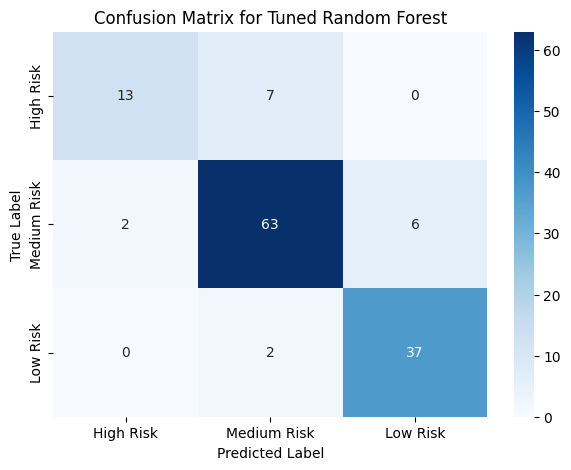

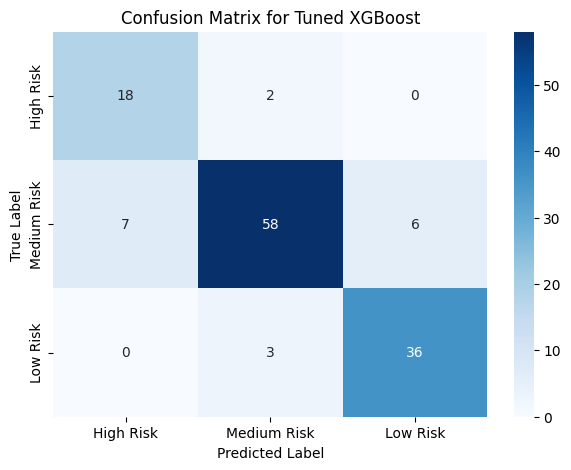

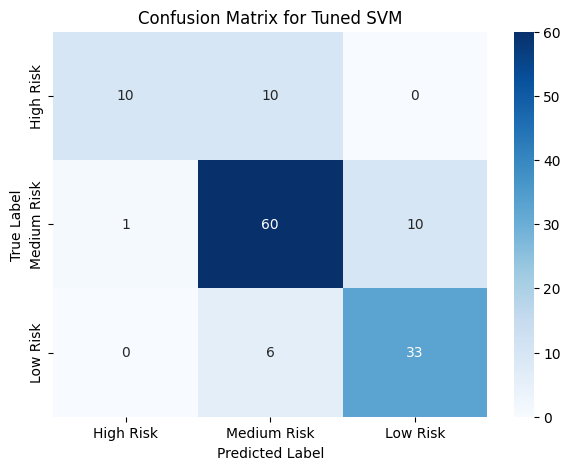

In [ ]:
# ==============================================================================
# ## Visualize Confusion Matrices
# ==============================================================================

# Helper function to plot a confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['High Risk', 'Medium Risk', 'Low Risk'],
                yticklabels=['High Risk', 'Medium Risk', 'Low Risk'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

print("\n\n===== Generating Confusion Matrix Plots =====")

# Generate plot for each model using the stored predictions
plot_confusion_matrix(y_test, model_results['Logistic Regression']['predictions'], 'Tuned Logistic Regression')
plot_confusion_matrix(y_test, model_results['Random Forest']['predictions'], 'Tuned Random Forest')
plot_confusion_matrix(y_test, model_results['XGBoost']['predictions'], 'Tuned XGBoost')
plot_confusion_matrix(y_test, model_results['Support Vector Machine']['predictions'], 'Tuned SVM') # <-- ADDED



===== Generating Feature Importance Plots =====

Plotting for Random Forest...


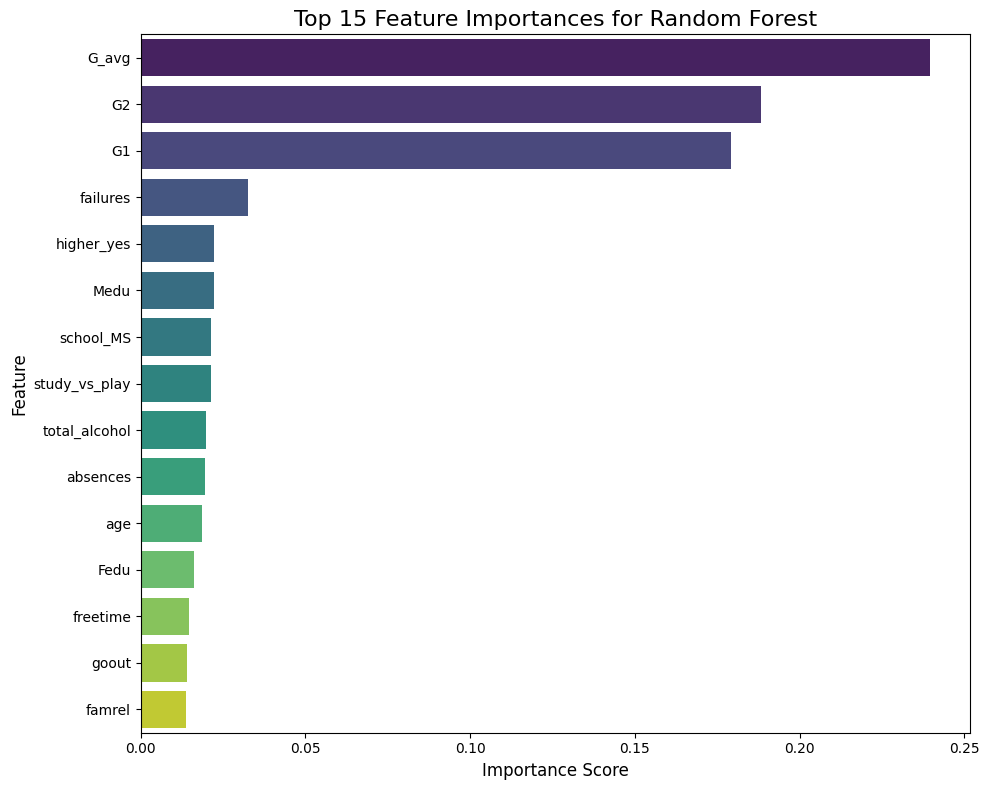

Plotting for XGBoost...


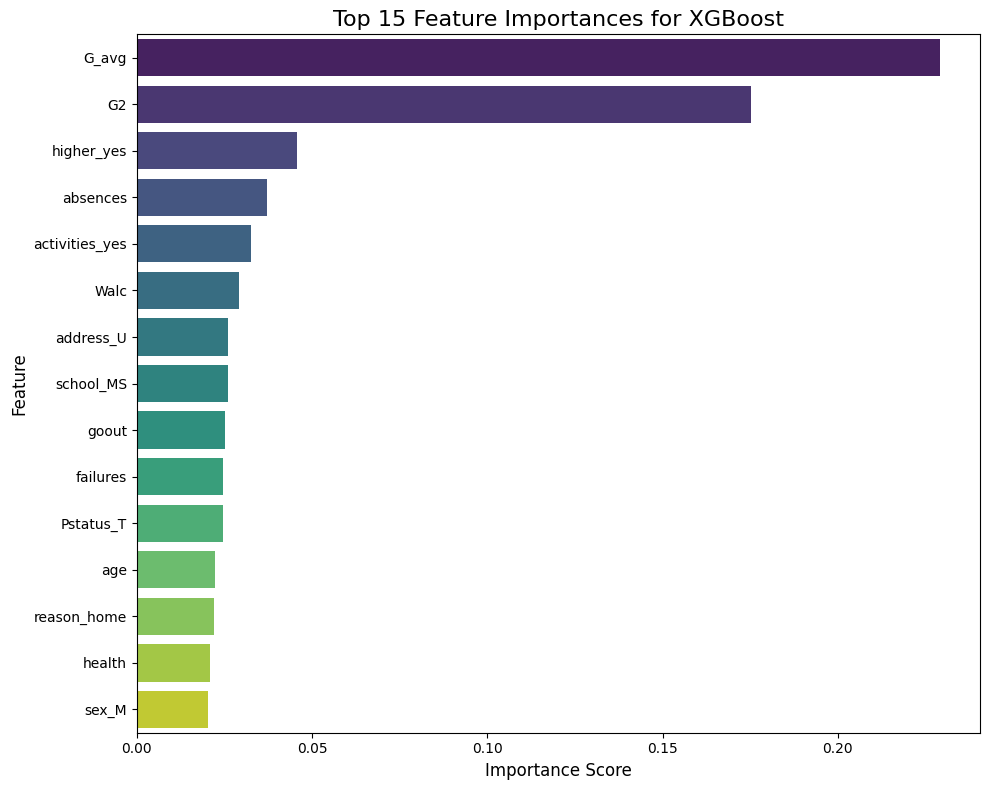


Feature importance plots generated and saved.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n\n===== Generating Feature Importance Plots =====\n")

# --- Function to Plot Feature Importance ---
def plot_feature_importance(model, feature_names, model_name):
    # Create a dataframe for feature importances
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(15) # Display top 15

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
    plt.title(f'Top 15 Feature Importances for {model_name}', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_feature_importance.png')
    plt.show()

# --- Retrieve feature names from the training data columns ---
# Ensure X_train is available from the previous cells
feature_names = X_train.columns

# --- Generate and save plot for Random Forest ---
print("Plotting for Random Forest...")
plot_feature_importance(trained_models['Random Forest'], feature_names, 'Random Forest')

# --- Generate and save plot for XGBoost ---
print("Plotting for XGBoost...")
plot_feature_importance(trained_models['XGBoost'], feature_names, 'XGBoost')

print("\nFeature importance plots generated and saved.")